In [90]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# prediction imports
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import ruptures as rpt

from scipy.stats import probplot

# sns.set_style('whitegrid')

# plt.switch_backend('agg')

sns.set(context='paper', style='whitegrid',  font_scale=1, font='Arial', 
        rc={"axes.edgecolor": "black", "grid.color": "lightgrey",
            "xtick.direction": "out", "ytick.direction": "out"}) # font='DejaVu Sans',

# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = 1
# no minor ticks
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.minor.size'] = 0
# axlines should be thin
plt.rcParams['axes.linewidth'] = 0.3
plt.rcParams['lines.linewidth'] = 0.3

### 1. Data examination

In [2]:
data = pd.read_csv('../data/age_estimations.csv')
data.head(10)

,lemma_,count,pos,lemma,freq,pos_fr,number_of_meanings,etymology,age
0,salon@NOUN,31950,NOUN,salon,6.085083e-05,substantif,6,1550.0,470.0
1,humoriste@NOUN,2731,NOUN,humoriste,5.201365e-06,substantif,1,1578.0,442.0
2,caricaturiste@NOUN,983,NOUN,caricaturiste,1.872187e-06,substantif,1,1803.0,217.0
3,dessinateur@NOUN,9436,NOUN,dessinateur,1.797147e-05,substantif,2,1667.0,353.0
4,humoristique@ADJ,5340,ADJ,humoristique,1.017037e-05,adjectif,1,1801.0,219.0
5,organiser@VERB,107773,VERB,organiser,2.052606e-04,verbe,4,1510.0,510.0
6,humoriste@ADJ,185,ADJ,humoriste,3.523444e-07,adjectif,1,1578.0,442.0
7,comité@NOUN,70991,NOUN,comité,1.352069e-04,substantif,2,1652.0,368.0
8,mondial@ADJ,168240,ADJ,mondial,3.204239e-04,adjectif,1,1550.0,470.0
9,gus@NOUN,341,NOUN,gus,6.494565e-07,substantif,1,1954.0,66.0


In [3]:
# Text summary for the SI

grouped_df = data.groupby('pos')

def format_output(group):
    pos = group['pos'].iloc[0]
    lemmas = group.apply(lambda row: f"{row['lemma']} ({row['etymology']})", axis=1)
    return f"{pos.capitalize()}: {', '.join(lemmas)}"

formatted_text = '\n'.join(grouped_df.apply(format_output))

with open('../data/formatted_output.txt', 'w') as file:
    file.write(formatted_text)


In [4]:
data.shape

(10472, 9)

In [5]:
data['rank'] = data['count'].rank(ascending=False)

In [6]:
data.shape

(10472, 10)

In [7]:
# number of senses / number of words
data.shape[0] / data['number_of_meanings'].sum()

0.5743117253482505

In [8]:
# # with open('../data/lemma_freq.pkl', 'rb') as f:
# #     lemma_freq = pickle.load(f)

# # remove elements with count < 100
# lemma_freq_ = {k: v for k, v in lemma_freq.items() if v['count'] > 100}

# # get all the lemmas that have same pos as in data['pos']
# lemma_freq_ = {k: v for k, v in lemma_freq_.items() if v['pos'] in data['pos'].unique()}

# # share of lemmas that appeared after the 1500s 
# data.shape[0] / len(lemma_freq_)

In [9]:
# print min and max number of meanings
print(data['number_of_meanings'].min(), data['number_of_meanings'].max())

1 12


In [10]:
# print min and max number of meanings
print(data['age'].min(), data['age'].max())

36.0 520.0


In [11]:
# del lemma_freq
# del lemma_freq_

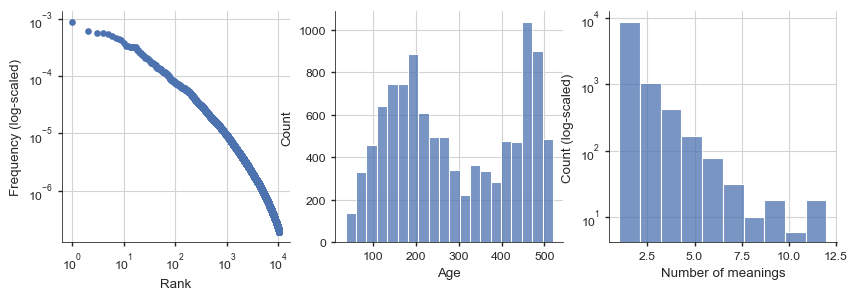

In [74]:
# plot distribuion of frequency, age, number of meanings in data on the same plot with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
# first axis should be rank-frequency plot from data['count']
sns.scatterplot(x='rank', y='freq', data=data, ax=ax[0], linewidth = 0)
sns.histplot(data['age'], stat='count', ax=ax[1])
sns.histplot(data['number_of_meanings'], stat='count', ax=ax[2], bins=10)
# log scales in axes 0 and 2
# 1 axis should be log-log
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[2].set_yscale('log')
# ax[2].set_xlim(1)
# remove y axis labels for axes 1 and 2
ax[0].set_ylabel('Frequency (log-scaled)')
ax[1].set_ylabel('Count')
ax[2].set_ylabel('Count (log-scaled)')
ax[0].set_xlabel('Rank')
ax[1].set_xlabel('Age')
ax[2].set_xlabel('Number of meanings')
sns.despine()
plt.show()

### 2. Get frequencies from n-gram

In [11]:
# def get_ngram(query, start_year=1800, end_year=2019, 
#             corpus='fr-2019'):
#     time.sleep(np.random.uniform(0.5, 3))
#     url = f'https://books.google.com/ngrams/json?content={query}&year_start={start_year}&year_end={end_year}&corpus={corpus}&smoothing=0'
#     response = requests.get(url)
#     data = response.json() 
#     return data[0]['timeseries'] if data else None

In [12]:
# data_1800 = data[data['etymology'] >= 1800]
# data_1800.shape

In [13]:
# # get ngram frequencies for each word and save them in a long format with columns word, year, freq, etymology

# freq = []
# for i, row in tqdm(data_1800.iterrows(), total=data_1800.shape[0]):
#     word = row['lemma']
#     etymology = row['etymology']
#     pos = row['pos']
#     try:
#         ngram = get_ngram(f'{word}_{pos}')
#         if ngram:
#             for i, freq_ in enumerate(ngram):
#                 freq.append([word, i, freq_, etymology])
#     except:
#         pass

# df1800_freq = pd.DataFrame(freq, columns=['word', 'year', 'freq', 'etymology'])

In [14]:
# df1800_freq['freq_scaled'] = df1800_freq.groupby('word')['freq'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# # convert df so that each word appears only once and has a column where the frequency time-series is stored as numpy array
# df1800_freq_ = df1800_freq.groupby('word')['freq_scaled'].apply(list).reset_index()
# df1800_freq_['freq_scaled'] = df1800_freq_['freq_scaled'].apply(lambda x: np.array(x))
# df1800_freq_['etymology'] = df1800_freq.groupby('word')['etymology'].apply(list).reset_index()['etymology'].apply(lambda x: x[0])

In [15]:
# # only keep if freq_scaled shape is 220,
# # if not, remove
# df1800_freq_['freq_scaled_len'] = df1800_freq_['freq_scaled'].apply(lambda x: x.shape[0])
# df1800_freq_ = df1800_freq_[df1800_freq_['freq_scaled_len'] == 220]

In [16]:
# df1800_freq_.shape

In [23]:
# df1800_freq_.to_csv('../data/df1800_freq_.csv', index=False)
# open df1800_freq_
df1800_freq_ = pd.read_csv('../data/df1800_freq_.csv')

In [24]:
# convert strings in freq_scaled column to numpy arrays
df1800_freq_['freq_scaled'] = df1800_freq_['freq_scaled'].apply(lambda x: np.array([float(i) for i in x[1:-1].split()]))

### 3. Change point prediction

In [25]:
class ChangePointRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, penalty=0.2, model="rbf", jump=2):
        self.penalty = penalty
        self.model = model
        self.jump = jump

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        result = []

        for time_series in X:
            # add jump
            algo = rpt.Pelt(model=self.model).fit(time_series)
            change_point = algo.predict(pen=self.penalty)[0]
            result.append(change_point)

        return np.array(result)

    def get_params(self, deep=True):
        return {"penalty": self.penalty, "model": self.model, "jump": self.jump}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [26]:
def prepare_data(df):
    max_length = max(len(seq) for seq in df['freq_scaled'])
    X = np.zeros((len(df), max_length))

    for i, seq in enumerate(df['freq_scaled']):
        X[i, :len(seq)] = seq

    y = np.array(df['etymology'])
    y = y - 1800
    return X, y

In [27]:
X, y = prepare_data(df1800_freq_)
X.shape

(3960, 220)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [29]:
X_train.shape

(3168, 220)

In [30]:
# # use GridSearchCV to find the best penalty value for the classifier and the best model ('rbf', 'l1, 'l2')
# from sklearn.model_selection import GridSearchCV

# param_grid = {'penalty': np.linspace(0, 1, 10), 'model': ['rbf', 'l1', 'l2'], 'jump': np.arange(2, 20, 5)}

# clf = GridSearchCV(ChangePointRegressor(), 
#                    param_grid, 
#                    cv=5, 
#                    scoring='explained_variance', 
#                    n_jobs=-1, 
#                    verbose=10)

In [31]:
# clf.fit(X_train, y_train)

In [32]:
# clf.best_params_

In [33]:
# clf.best_score_

In [34]:
# pass clf.best_params_ to ChangePointRegressor and fit it on the whole dataset
# model = ChangePointRegressor(**clf.best_params_)
model = ChangePointRegressor(penalty=0.1, model='l1', jump=2)
model.fit(X_test, y_test)

# plot predicted vs true
y_pred = model.predict(X_test)

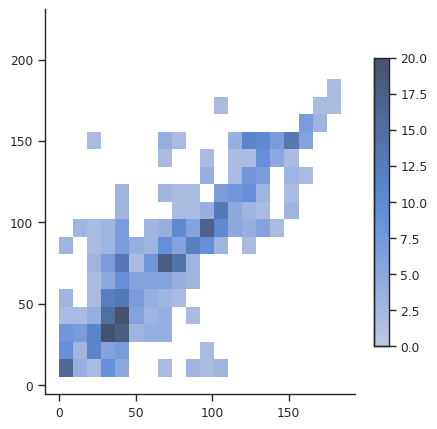

In [38]:
plt.figure(figsize=(5, 5))
sns.histplot(x = y_test, 
             y = y_pred, 
             bins=20, 
             cbar=True, 
             cbar_kws=dict(shrink=.75),
             thresh=1)
sns.despine()
plt.show()

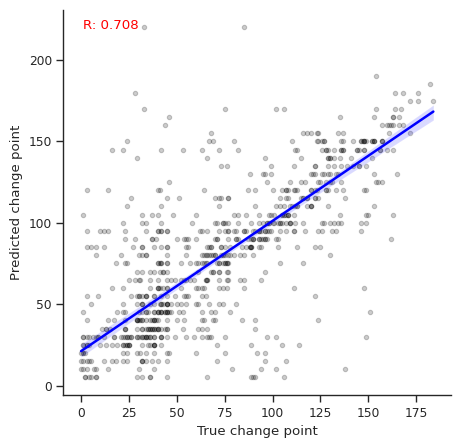

In [39]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.2, color='black', s=10)
# add a regplot
sns.regplot(x=y_test, y=y_pred, scatter=False, color='blue', robust=True)
plt.xlabel('True change point')
plt.ylabel('Predicted change point')
# add the amount of explained variance in top left corner
plt.text(0.05, 0.95, f'R: {np.corrcoef(y_test, y_pred)[0, 1]:.3f}', 
         transform=plt.gca().transAxes, color='red')
sns.despine()
plt.show()

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

sns.scatterplot(x=y_test, y=y_pred, alpha=0.2, ax=ax[0], size=5,
                legend=False, linewidth=0)
sns.regplot(x=y_test, y=y_pred, scatter=False, color='blue', robust=True, ax=ax[0])
ax[0].set_xlabel('True change point')
ax[0].set_ylabel('Predicted change point')
ax[0].text(0.1, 0.95, f'R: {np.corrcoef(y_test, y_pred)[0, 1]:.3f}', 
           transform=ax[0].transAxes, color='black',
           ha='center', va='center', fontsize=10)
ax[0].text(-0.1, 1.05, 'A', transform=ax[0].transAxes, fontsize=14, fontweight='bold')

sns.scatterplot(x=y_pred, y=y_test - y_pred, 
                s=20, ax=ax[1], linewidth=0, 
                alpha=0.2, size=5,
                legend=False,)
ax[1].set_xlabel('Predicted change point')
ax[1].set_ylabel('Residuals')
ax[1].text(-0.1, 1.05, 'B', transform=ax[1].transAxes, fontsize=14, fontweight='bold')

sns.histplot(y=y_test - y_pred, bins=50, ax=ax[2])
ax[2].set_ylabel('Residuals')
ax[2].set_xlabel('Count')
ax[2].text(-0.1, 1.05, 'C', transform=ax[2].transAxes, fontsize=14, fontweight='bold')

plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots
# sns.despine()

plt.show()
# save to pdf
fig.savefig('../figures/age_estimations.pdf', bbox_inches='tight')

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_3091/720403692.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


### 4. Residual subsetting

In [43]:
# pass clf.best_params_ to ChangePointRegressor and fit it on the whole dataset
# model = ChangePointRegressor(**clf.best_params_)
# model.fit(X, y)

# plot predicted vs true
y_ = model.predict(X)

In [44]:
y_.shape

(3960,)

In [45]:
y.shape

(3960,)

In [46]:
df1800_freq_ = df1800_freq_.assign(residual = y - y_, prediction = y_, tlfi = y)

In [47]:
# high = np.mean(y - y_) + 1 * np.std(y - y_)
# low = np.mean(y - y_) - 1 * np.std(y - y_)
high = 30
low = -30

In [48]:
# only select words with residuals between high and low
df1800_freq_ = df1800_freq_[(df1800_freq_['residual'] <= high) & (df1800_freq_['residual'] >= low)]
df1800_freq_.shape

(2909, 7)

In [49]:
data_1800 = data[data['etymology'] >= 1800]

In [50]:
# select lemmas from data_1800 that are in df1800_freq_ by matching by lemmas and etymology
data_1800_res = data_1800.merge(df1800_freq_, left_on=['lemma', 'etymology'], right_on=['word', 'etymology'], how='inner')

In [51]:
data_1800_res.to_csv('../data/age_estimation_1800.csv', index=False)

In [52]:
data_1800_res

,lemma_,count,pos,lemma,freq,pos_fr,number_of_meanings,etymology,age,rank,word,freq_scaled,freq_scaled_len,residual,prediction,tlfi
0,caricaturiste@NOUN,983,NOUN,caricaturiste,1.872187e-06,substantif,1,1803.0,217.0,3292.0,caricaturiste,"[0.01214608, 0.0, 0.0, 0.01131665, 0.02391518,...",220,-27.0,30,3.0
1,humoristique@ADJ,5340,ADJ,humoristique,1.017037e-05,adjectif,1,1801.0,219.0,921.0,humoristique,"[0.00740750234, 0.00336974909, 0.0, 0.0, 0.001...",220,-29.0,30,1.0
2,marginaliser@VERB,1162,VERB,marginaliser,2.213104e-06,verbe,2,1964.0,56.0,2955.5,marginaliser,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",220,-6.0,170,164.0
3,gouvernemental@ADJ,13421,ADJ,gouvernemental,2.556116e-05,adjectif,2,1801.0,219.0,376.0,gouvernemental,"[0.00765389316, 0.00502931695, 0.0, 0.00221860...",220,-29.0,30,1.0
4,confessionnel@ADJ,979,ADJ,confessionnel,1.864569e-06,adjectif,1,1863.0,157.0,3302.5,confessionnel,"[0.00196332453, 0.00148856089, 0.0, 0.0, 0.0, ...",220,18.0,45,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,concasseur@NOUN,103,NOUN,concasseur,1.961701e-07,substantif,1,1838.0,182.0,10380.5,concasseur,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",220,-17.0,55,38.0
2908,radiculaire@ADJ,114,ADJ,radiculaire,2.171203e-07,adjectif,1,1817.0,203.0,10020.0,radiculaire,"[0.00143440433, 0.0, 0.0, 0.000890967778, 0.00...",220,7.0,10,17.0
2909,primitivisme@NOUN,103,NOUN,primitivisme,1.961701e-07,substantif,2,1904.0,116.0,10380.5,primitivisme,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",220,-1.0,105,104.0
2910,tartrique@ADJ,152,ADJ,tartrique,2.894938e-07,adjectif,1,1823.0,197.0,8954.5,tartrique,"[0.0247239151, 0.0, 0.000503917288, 0.00043877...",220,3.0,20,23.0


In [89]:
# plot 10 time series with predicted change points vs. true change points
fig, ax = plt.subplots(2, 3, figsize=(10, 4))
ax = ax.flatten()

for i in range(6):
    ax[i].plot(data_1800_res['freq_scaled'][i], color='grey', linewidth=2, alpha=1)
    ax[i].axvline(x=data_1800_res['prediction'][i], color='r', label='PELT', linewidth=2)
    ax[i].axvline(x=data_1800_res['tlfi'][i], color='g', label='TLFi', linewidth=2)
    ax[i].set_title(f'{data_1800_res["lemma"][i]}')
    ax[i].set_xticks(np.arange(0, 220, 40), np.arange(1800, 2020, 40))
    
    if i not in [2, 5]:
        ax[i].text((data_1800_res['prediction'][i] + data_1800_res['tlfi'][i]) / 2, 0.57, 
                   f'{data_1800_res["residual"][i].round(0).astype(int)}', 
                   ha='center', va='center', color='black', size=7,)
        # add a two-sided arrow
        ax[i].annotate('', xy=(data_1800_res['prediction'][i], 0.5), xytext=(data_1800_res['tlfi'][i], 0.5),
                       arrowprops=dict(arrowstyle='<->', color='black'))

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
plt.tight_layout()
# sns.despine()
fig.savefig('../figures/age_estimations_10.pdf', bbox_inches='tight', dpi=400)
plt.show()

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_3091/3834691857.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


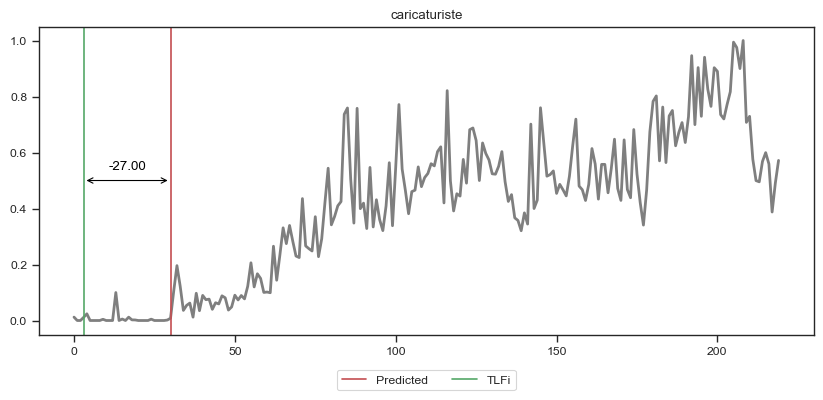

In [72]:
# plot the word 'caricaturiste'
plt.figure(figsize=(10, 4))
plt.plot(data_1800_res['freq_scaled'][data_1800_res['lemma'] == 'caricaturiste'].values[0], color='black', linewidth=2, alpha=0.5)

plt.axvline(x=data_1800_res['prediction'][data_1800_res['lemma'] == 'caricaturiste'].values[0], color='r', label='Predicted')
plt.axvline(x=data_1800_res['tlfi'][data_1800_res['lemma'] == 'caricaturiste'].values[0], color='g', label='TLFi')
# add a two-sided arrow between the two vertical lines
plt.annotate('', xy=(data_1800_res['prediction'][data_1800_res['lemma'] == 'caricaturiste'].values[0], 0.5), 
             xytext=(data_1800_res['tlfi'][data_1800_res['lemma'] == 'caricaturiste'].values[0], 0.5),
             arrowprops=dict(arrowstyle='<->', color='black'))
# add word residual on top of the arrow
plt.text((data_1800_res['prediction'][data_1800_res['lemma'] == 'caricaturiste'].values[0] + data_1800_res['tlfi'][data_1800_res['lemma'] == 'caricaturiste'].values[0]) / 2, 0.55, 
         f'{data_1800_res["residual"][data_1800_res["lemma"] == "caricaturiste"].values[0]:.2f}', 
         ha='center', va='center', color='black')
plt.title('caricaturiste')
# legend at the bottom left in one row
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
# plt.legend()
plt.show()